# Text Sentiment Analysis on IMDB dataset

This notebook contains a sentiment analysis model to classify movie reviews as **positive** or **negative**. We will use the IMDB movie review dataset (https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) for developing the model. 

It contains 50000 reviews, which is divided into train and test sets of 25000 reviews each.

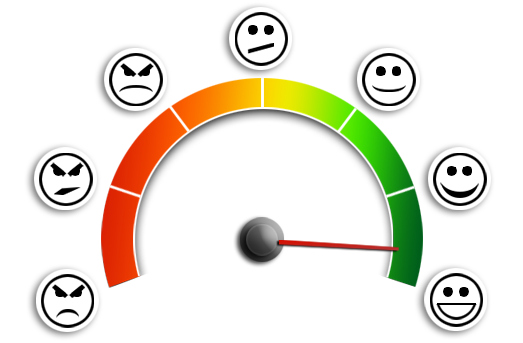

In [17]:
# Import libraries

import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)

2.3.1


### Load Dataset

Tensorflow provides an easy way to download the data using Tensorflow datasets. 

In [2]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Separate text sentences and labels from both train and test sets.

In [3]:
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [4]:
print(f"length of training sentences: {len(training_sentences)}")
print(f"length of training labels: {len(training_labels_final)}")
print(f"length of testing sentences: {len(testing_sentences)}")
print(f"length of testing labels: {len(testing_labels_final)}")

length of training sentences: 25000
length of training labels: 25000
length of testing sentences: 25000
length of testing labels: 25000


In [5]:
print(np.unique(training_labels_final, return_counts=True))
print(np.unique(testing_labels_final, return_counts=True))

(array([0, 1], dtype=int64), array([12500, 12500], dtype=int64))
(array([0, 1], dtype=int64), array([12500, 12500], dtype=int64))


Both training and test data are equally divided into positive(1) and negative(0) labels

In [6]:
vocab_size = 10000     # max length of vocabulary (no. of unique words)
embedding_dim = 16     # dimension of embedding layer
max_length = 120       # maximum length of all sequences
trunc_type='post'      # position from where to truncate larger sentences 
oov_tok = "<OOV>"      # token to replace 'Out of vocabulary' words


# Create Tokenizer object which will be used to convert sentences into numeric sequence vectors 
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Use training data to train/fit the Tokenizer with
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index


# sequences = tokenizer.texts_to_sequences(training_sentences)
# padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
# testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [7]:
# Define function to convert sentences into numeric sequence vectors (trained on vocabulary of training data) 
def transform_string(sentences):
    return pad_sequences(tokenizer.texts_to_sequences(sentences),maxlen=max_length, truncating=trunc_type)

In [8]:
training_sequence = transform_string(training_sentences)
testing_sequence = transform_string(testing_sentences)

Lets visualize how a sentence looks after it gets transformed using *word_index* (adjusted length, padded, matched with vocabulary)

In [9]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print('Original sentence:')
print(training_sentences[15])
print('\nTransformed sentence:')
print(decode_review(training_sequence[15]))

Original sentence:
It was disgusting and painful. What a waste of a cast! I swear, the audience (1/2 full) laughed TWICE in 90 minutes. This is not a lie. Do not even rent it.<br /><br />Zeta Jones was just too mean to be believable.<br /><br />Cusack was OK. Just OK. I felt sorry for him (the actor) in case people remember this mess.<br /><br />Roberts was the same as she always is. Charming and sweet, but with no purpose. The "romance" with John was completely unbelievable.

Transformed sentence:
? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? it was disgusting and painful what a waste of a cast i swear the audience 1 2 full laughed twice in 90 minutes this is not a lie do not even rent it br br zeta jones was just too mean to be believable br br cusack was ok just ok i felt sorry for him the actor in case people remember this mess br br roberts was the same as she always is charming and sweet but with no purpose the romance with john was completely unbelievable


### Define Model

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`. 
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

### Loss function and optimizer

Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a `sigmoid` activation), we'll use `binary_crossentropy` loss function.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
dropout (Dropout)            (None, 120, 16)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
_________________________________________________________________


### Train the Model

In [13]:
num_epochs = 10
history = model.fit(training_sequence, training_labels_final, epochs=num_epochs, validation_data=(testing_sequence, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 5s 7ms/step - loss: 0.6392 - accuracy: 0.6990 - val_loss: 0.5678 - val_accuracy: 0.7664
Epoch 2/10
782/782 [==============================] - 5s 7ms/step - loss: 0.4921 - accuracy: 0.8084 - val_loss: 0.4604 - val_accuracy: 0.8102
Epoch 3/10
782/782 [==============================] - 5s 7ms/step - loss: 0.4032 - accuracy: 0.8439 - val_loss: 0.4105 - val_accuracy: 0.8234
Epoch 4/10
782/782 [==============================] - 5s 7ms/step - loss: 0.3543 - accuracy: 0.8588 - val_loss: 0.3863 - val_accuracy: 0.8301
Epoch 5/10
782/782 [==============================] - 5s 7ms/step - loss: 0.3209 - accuracy: 0.8714 - val_loss: 0.3738 - val_accuracy: 0.8342
Epoch 6/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2978 - accuracy: 0.8832 - val_loss: 0.3660 - val_accuracy: 0.8374
Epoch 7/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2783 - accuracy: 0.8888 - val_loss: 0.3644 - val_accuracy: 0.8397
Epoch 

In [14]:
loss, accuracy = model.evaluate(testing_sequence, testing_labels_final)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3726 - accuracy: 0.8359
Loss:  0.3725755512714386
Accuracy:  0.8358799815177917


We have achieved an accurracy of ~84% with a relatively simple model.

In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

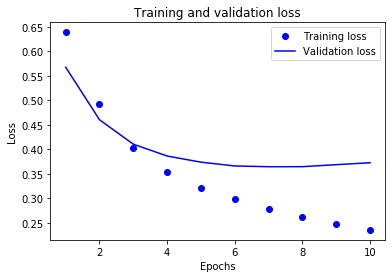

In [18]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

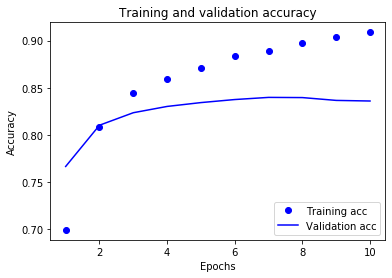

In [19]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Inference on new data

To get predictions for new examples, we can simply call `model.predict()`.

In [20]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

In [21]:
model.predict(transform_string(examples))

array([[0.8249099],
       [0.6886179],
       [0.5098226]], dtype=float32)